___

# Plant classification model by disease

___

Plant image classification model based on the public PlantVillage dataset. Before this, we manually cleaned data that we considered unnecessary and combined data that had the same disease to make it more compact.

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import PIL
# Version 2.15.0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow as tf
import keras
from keras import layers

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import backend as K

# Establece la semilla global para reproducibilidad
tf.random.set_seed(42)

ModuleNotFoundError: No module named 'tensorflow'

____

## Data extraction

In [28]:
tf.random.set_seed(42)
data_dir = 'plantas_por_enfermedad'

# Cargamos el nuevo dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 14969 files belonging to 11 classes.
Using 11976 files for training.
Found 14969 files belonging to 11 classes.
Using 2993 files for validation.


In [ ]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Black_Measles', 'Black_rot', 'Desconocido', 'Early_blight', 'Late_blight', 'Leaf_scorch', 'Rust', 'Scab', 'Sin plaga', 'Spot']


In [ ]:
# Configure the dataset for performance

# `AUTOTUNE` allows TensorFlow to automatically adjust the buffer size for optimal performance.
AUTOTUNE = tf.data.AUTOTUNE

# `shuffle(buffer_size)` shuffles the data in the dataset with a buffer of size `buffer_size`.
# This helps avoid patterns in the data that could cause the model to learn incorrectly.
# In this case, the buffer has a size of 1000.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# `cache()` saves data in memory after the first load to avoid repeated reads from disk.
# This is useful if your dataset fits in memory and you want to speed up training.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Create a basic Keras model with data augmentation and dropout

# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),  # Increase rotation range
    layers.RandomZoom(0.2),      # Increase zoom range
    layers.RandomContrast(0.3),  # Increase contrast
    layers.RandomBrightness(0.2) # Add shine
  ]
)


#layers.BatchNormalization(),

# Normalizes the outputs of the previous layer to stabilize and speed up training.

#layers.MaxPooling2D(),

# Applies a max pooling operation to reduce the spatial dimensions (width and height) of the features.

#layers.GlobalAveragePooling2D(),

# Performs a global average over all spatial features to reduce the tensor to a single dimension.

#layers.Dropout(0.4),
# Applies dropout at a rate of 40% to reduce overfitting during training.

# Create the model
num_classes = len(class_names)

model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)), # Define input form
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax', name="outputs")
])

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

# Configure the Adam optimizer with a learning rate of 0.0001
model.compile(optimizer=Adam(learning_rate=1e-4),  
              
# Define the loss function for multiclass classification
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              
# Use 'accuracy' as an evaluation metric
              metrics=['accuracy'])

Epoch 1/15
375/375 [==============================] - 93s 211ms/step - loss: 1.4008 - accuracy: 0.5551 - val_loss: 3.1376 - val_accuracy: 0.2589
Epoch 2/15
375/375 [==============================] - 116s 310ms/step - loss: 0.8173 - accuracy: 0.7328 - val_loss: 0.8655 - val_accuracy: 0.7016
Epoch 3/15
375/375 [==============================] - 125s 334ms/step - loss: 0.6375 - accuracy: 0.7909 - val_loss: 1.2335 - val_accuracy: 0.6335
Epoch 4/15
375/375 [==============================] - 111s 295ms/step - loss: 0.5353 - accuracy: 0.8263 - val_loss: 0.8972 - val_accuracy: 0.7267
Epoch 5/15
375/375 [==============================] - 128s 340ms/step - loss: 0.4569 - accuracy: 0.8496 - val_loss: 1.1009 - val_accuracy: 0.6940
Epoch 6/15
375/375 [==============================] - 93s 249ms/step - loss: 0.4036 - accuracy: 0.8676 - val_loss: 1.7436 - val_accuracy: 0.6158
Epoch 7/15
375/375 [==============================] - 123s 329ms/step - loss: 0.3574 - accuracy: 0.8820 - val_loss: 1.2613 - v

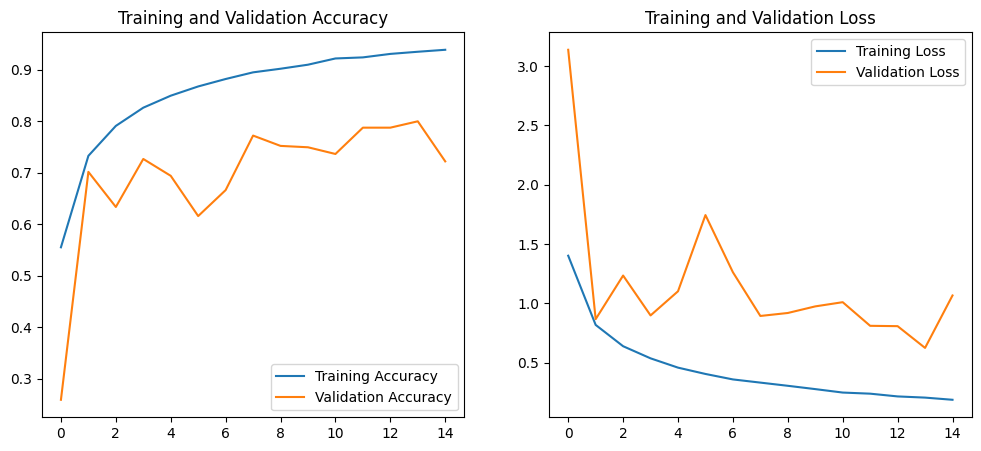

In [ ]:
# Definir callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('plant_disease_model_best.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15, 
  callbacks=callbacks
)

# View training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predict on new data
img_path = 'test5.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Crear un batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
   "This image probably belongs to {} with a confidence of {:.2f} percent."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 66ms/step
Esta imagen probablemente pertenece a Bacterial_spot con una confianza del 20.22 por ciento.


In [40]:
import tensorflow as tf
import numpy as np

# Cargar el modelo guardado
modelo_final = tf.keras.models.load_model('plant_disease_model_best.keras')

In [ ]:
# Create a converter for TensorFlow Lite with optimization
converter = tf.lite.TFLiteConverter.from_keras_model(modelo_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 16, Total Ops 60, % non-converted = 26.67 %
 * 16 ARITH ops

- arith.constant:   16 occurrences  (f32: 11, i32: 5)



  (f32: 6)
  (i32: 1)
  (f32: 4)
  (f32: 3)
  (i32: 2)
  (f32: 5)
  (f32: 1)
  (f32: 5)

  (i32: 1)
  (uq_8: 6)
  (i32: 2)
  (f32: 2)
  (i32: 1)
  (f32: 1)


In [ ]:
# Comentario para explicar los operadores no convertidos

# La salida anterior indica que durante la conversión del modelo a TensorFlow Lite,
# algunos operadores no se pudieron convertir a las fórmulas específicas de TensorFlow Lite.

# En este caso, 16 de los 60 operadores (26.67%) no se convirtieron y se etiquetaron como
# "ARITH ops" (operaciones aritméticas). Estos operadores incluyen constantes en formatos
# de punto flotante (f32) e integer (i32).

# Los operadores no convertidos pueden afectar la eficiencia del modelo, ya que estos
# operadores tendrán que ejecutarse en su forma original en lugar de en una versión
# optimizada para TensorFlow Lite. 

#Sin embargo, el modelo debería seguir funcionando correctamente en la mayoría de los casos. 

In [44]:
# Guardar el modelo TFLite en un archivo
with open('modelo_final_final.tflite', 'wb') as f:
    f.write(tflite_model)

print("Guardado")

Guardado


___